# TimeSeries - ARIMA

# Setup

In [208]:
!pip install ruptures

     |████████████████████████████████| 61kB 719kB/s eta 0:00:01


In [12]:
!conda install beautifulsoup4 --yes

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::pandas-profiling==2.2.0=py_0
  - conda-forge/noarch::pytest-openfiles==0.3.1=py_0
  - conda-forge/osx-64::astropy==3.2.1=py36h01d97ff_0
  - conda-forge/noarch::pytest-doctestplus==0.3.0=py_0
  - conda-forge/noarch::pytest-arraydiff==0.3=py_0
  - conda-forge/noarch::pytest-remotedata==0.3.1=py_0
  - districtdatalabs/osx-64::yellowbrick==0.9.1=py36_0
  - conda-forge/noarch::pytest-runner==5.1=py_0
  - conda-forge/noarch::pytest-astropy==0.5.0=py_0
  - conda-forge/noarch::pytest-pylint==0.14.0=py_0
  - conda-forge/noarch::phik==0.9.8=py_0
- 
  - https://repo.continuum.io/pkgs/main/osx-64::cvxcanon-0.1.1-py36h6440ff4_0
  - defaults::cvxcanon-0.1.1-py36h6440ff4done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.0

Please update conda by running

    $ conda update -

In [4]:
!pip install pyramid-arima

     |████████████████████████████████| 522kB 1.0MB/s eta 0:00:01
     |████████████████████████████████| 2.9MB 2.6MB/s eta 0:00:01
  Stored in directory: /Users/wilsons/Library/Caches/pip/wheels/e1/77/b6/9f6715144307ec94f7b9b67f648f858bd3b7d5d1f01fcb4346
Successfully built pyramid-arima


In [2]:
import warnings
warnings.filterwarnings('ignore')

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.statespace.tools import diff

from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import meanabs
from statsmodels.tools.eval_measures import aic

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARMAResults
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from pyramid.arima import auto_arima

import ruptures as rpt

from pylab import rcParams
rcParams['figure.figsize'] = 12,8

/Users/wilsons/anaconda3/envs/pyjup/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/wilsons/anaconda3/envs/pyjup/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Data
* http://nuforc.org/webreports/ndxevent.html
* Read in using requests & scrape with BeautifulSoup 
* Drop old values & unusable values
* Create data frame and resample to monthly

## Scrape

In [111]:
URL = 'http://www.nuforc.org/webreports/ndxevent.html'
html_content = requests.get(URL).text
soup = BeautifulSoup(html_content, 'html.parser')

In [112]:
results = []
table = soup.find('table')
for row in table.find_all('tr', attrs={'valign':'TOP'}):
    td = row.find_all('td')
    result = {'Date':td[0].text, 'Seen':td[1].text}
    results.append(result)

## Cleaning

In [260]:
df = pd.DataFrame(results)
df = df[:-12] # Drop Really Old
df['Seen'] = df['Seen'].astype(int) #Integer
df.tail()

,Date,Seen
836,06/1871,1
837,05/1864,2
838,03/1861,1
839,06/1838,1
840,04/1800,1


## Index

In [261]:
df.index = pd.DatetimeIndex(pd.to_datetime(df.Date, format='%m/%Y', errors='ignore'))
df = df.drop(columns='Date')
df = df.sort_index().asfreq('MS')
df = df.fillna(0)

## Plotting

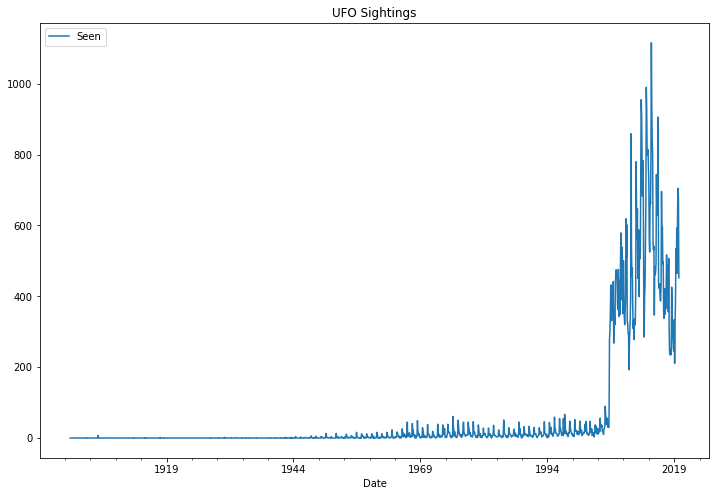

In [262]:
df = df['1900-01-01':]
df.plot(figsize=(12,8), title='UFO Sightings')

# Change Point
* Data takes a dramatic increase in 2016-04-01
* We'll use the Ruptures library to identify possible change points in the dataset 

In [263]:
df['2006-01-01':'2006-12-01']

,Seen
Date,
2006-01-01,50.0
2006-02-01,30.0
2006-03-01,61.0
2006-04-01,277.0
2006-05-01,302.0
2006-06-01,345.0
2006-07-01,432.0
2006-08-01,431.0
2006-09-01,331.0


## Model

In [264]:
algo = rpt.Pelt(model='rbf')
algo.fit(df[['Seen']])
result = algo.predict(pen=10)

## Plot

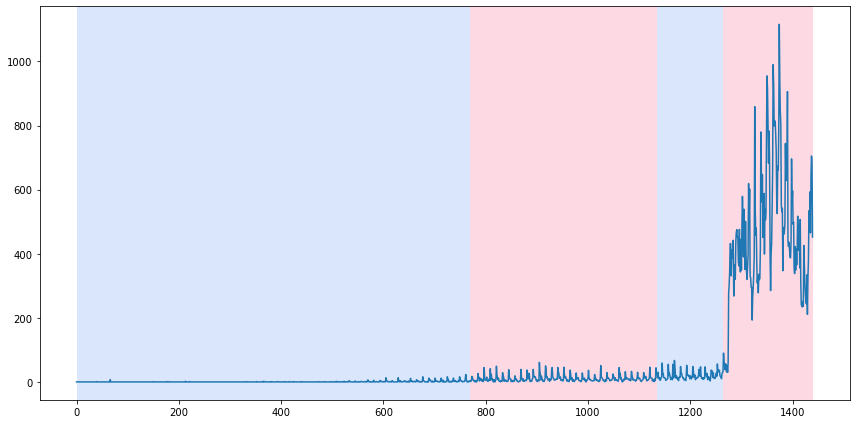

In [265]:
rpt.display(df[['Seen']], result, figsize=(12,6));

## Data Points

In [230]:
df.iloc[result[0:-1]]

,Seen,Diff-1,Diff-2,LogSeen,LogDiff-1
Date,,,,,
1964-05-01,4.0,2.0,3.0,1.609438,0.510826
1994-05-01,8.0,4.0,9.0,2.197225,0.587787
2005-03-01,26.0,16.0,22.0,3.295837,0.897942


## Filter

In [271]:
df = df['2005-03-01':]

# ARIMA
* Describes a process with three terms:
    * Auto Regressive - Current Value is a weighted sum of past values
    * Integrated - Differencing
    * Moving average - White noise or shocks to a system gradually reduced with time
* ARIMA models described with 3 values:
    * ARIMA(p, d, q)
    * p = number of auto regressive terms
    * d = number of differences
    * q = number of moving average terms
* Intuition
    * Linear models need stationarity (i.e. remove auto correlation)
    * To achieve stationarity we take a difference of the series itself
    * Taking differences removes the trend - I Term
    * Sometimes we over difference and need to add back - MA term
    * Sometimes differencing doesn't go far enough - AR term
* Approaches to Determining ARIMA order:
    * Heuristic using ACF and PACF plots
    * Grid search with loss (AIC)
    * Automated Search with Pyramid (AutoARIMA)

# Stationarity
* Stationarity is an assumption built into many of the techniques used for time series
* It simply means there is constant mean (no trend) and constant variance
* There are statistical tests like Augmented Dickey Fuller which test for stationarity

## Augmented Dickey-Fuller Test
* Tests for the presence of a unit root
* A unit root is a stochastic trend (random walk with drift)
* If a series has a unit root, it shows a systematic, unpredictable pattern

In [272]:
adfuller(df['Seen'])

(-2.6263141542701547,
 0.08767970381168144,
 13,
 164,
 {'1%': -3.47086589632514, '5%': -2.879330279087651, '10%': -2.57625492712671},
 1983.2440552100181)

In [4]:
?adfuller

## Wrapped

In [274]:
def stationarityTest(values, critical = 0.05):
    results = adfuller(values)
    print(f'Augmented Dickey-Fuller Statistic {results[0]}')
    print(f'  p-value {results[1]}')
    print(f'  Lags used {results[2]}')
    print(f'  Number observations {results[3]}')
    if results[1] < critical:
        print('Strong evidence to reject no unit roots')
        print('There is stationarity')
    else:
        print('Weak evidence to reject no unit roots')
        print('There is not stationarity')

In [275]:
stationarityTest(df['Seen'])

Augmented Dickey-Fuller Statistic -2.6263141542701547
  p-value 0.08767970381168144
  Lags used 13
  Number observations 164
Weak evidence to reject no unit roots
There is not stationarity


# Integrated - Differencing
* To make a time series stationary, we need to change it
* We can transform it (with Box Cox -- square, exponentiate, log)
* More customarily , we difference the sequence to make it stationary
* Differencing is the change between two consecutive data points in the series
* When we diff we lose a data point!!!

## Auto Correlation
* Our data set exhibits strong auto correlation

Text(0.5, 1.0, 'AutoCorrelation Original Data')

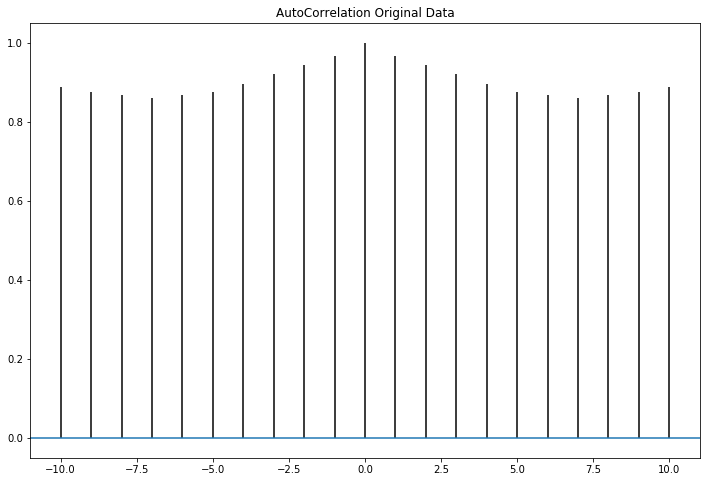

In [276]:
plt.figure(figsize=(12,8))
plt.acorr(df['Seen'])
plt.title('AutoCorrelation Original Data')

## Differencing Operator
* We'll use the diff operator in statsmodels
* Compute the first and second degree differences

In [277]:
df['Diff-1'] = diff(df)
df['Diff-2'] = diff(df['Diff-1'])
df.head()

,Seen,Diff-1,Diff-2
Date,,,
2005-03-01,26.0,NaN,NaN
2005-04-01,29.0,3.0,NaN
2005-05-01,33.0,4.0,1.0
2005-06-01,90.0,57.0,53.0
2005-07-01,62.0,-28.0,-85.0


In [278]:
df = df.dropna()

## Differenced Plots
* The differenced data look far more 
* Original Seen Data seems to have a trend up, then down
* Our differenced data appears to have been detrended

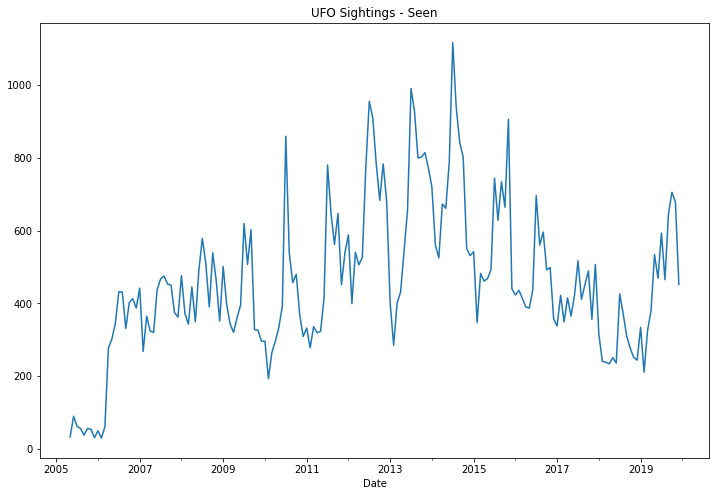

In [279]:
df['Seen'].plot(figsize=(12,8), title='UFO Sightings - Seen')

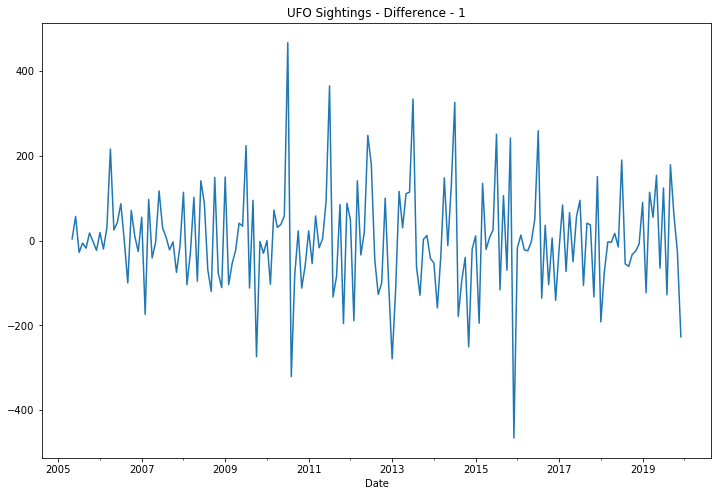

In [247]:
df['Diff-1'].plot(figsize=(12,8), title='UFO Sightings - Difference - 1')

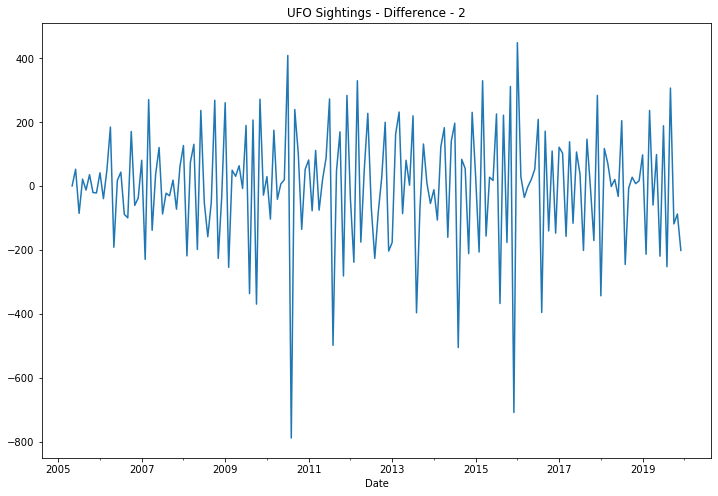

In [248]:
df['Diff-2'].plot(figsize=(12,8), title='UFO Sightings - Difference - 2')

## Stationary Tests

In [249]:
stationarityTest(df['Seen'].dropna())

Augmented Dickey-Fuller Statistic -2.362304407647466
  p-value 0.15265950255633592
  Lags used 13
  Number observations 162
Weak evidence to reject no unit roots
There is not stationarity


In [250]:
stationarityTest(df['Diff-1'].dropna())

Augmented Dickey-Fuller Statistic -3.5540212149710566
  p-value 0.006703387046010822
  Lags used 12
  Number observations 163
Strong evidence to reject no unit roots
There is stationarity


In [251]:
stationarityTest(df['Diff-2'].dropna())

Augmented Dickey-Fuller Statistic -8.735446942089945
  p-value 3.10931350427981e-14
  Lags used 13
  Number observations 162
Strong evidence to reject no unit roots
There is stationarity


## Auto Correlation Plot
* Data is perfectly correlated with itself at timestep t
* Data is slightly negatively correlated one timestep t-1
* Original data shows large autocorrelation - Take a difference & Check

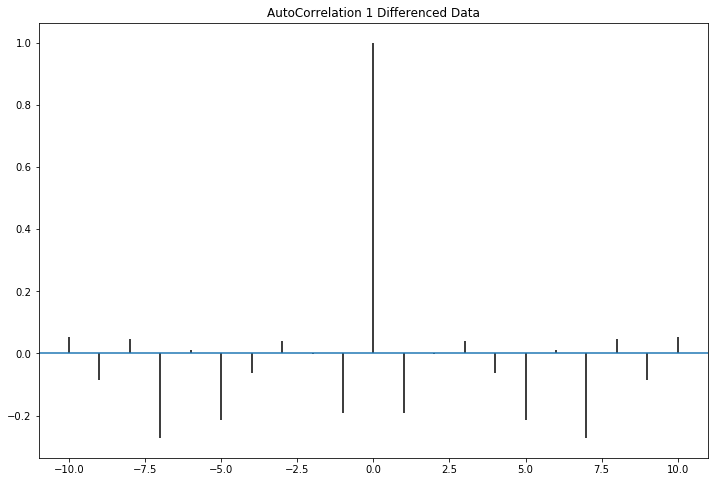

In [252]:
plt.figure(figsize=(12,8))
plt.acorr(df['Diff-1']);
plt.title('AutoCorrelation 1 Differenced Data');

# Moving Average - ACF Plot
* Related to acorr plot (right hand-side)
* Stands for auto correlation function 
* Also called a correlogram
* Shows serial correlation in the dataset
* Significance are indicated outside of shaded region
* MA Pattern:
    * Sharp cutoff
    * Lag 1 autocorrelation is negative
    * Series appears slightly over differenced
    * The lag at the ACF cutoff (of significance) indicates the number of terms
* This plot:
    * Lag 0 is at 1.0 (perfect correlation)
    * Lag 1 is negative and significant
    * Pattern indicates MA term of 1
    * Lag 12 significant - may indicate yearly seasonality

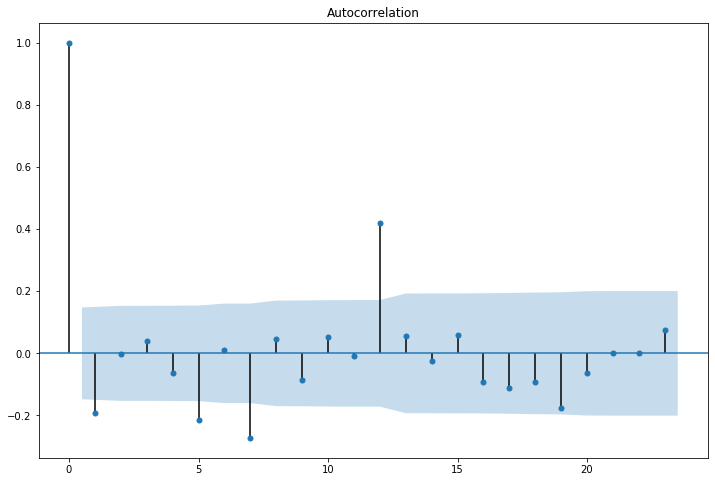

In [254]:
plot_acf(df['Diff-1']);

# Auto Regressive - PACF Plot
* PACF = Partial Auto Correlation Function Plot
* Measures the amount of correlation with each lag not accounted for by more recent lags
* For example PACF for Lag 0 and Lag 2 would measure the correlation between each while factoring out Lag 1
* AR Pattern:
    * Steep dropoff 
    * Lag 1 positive
    * Series appears slightly under differenced
* This plot:
    * Steep dropoff
    * Negative Lag 1
    * Pattern doesn't indicate an AR term

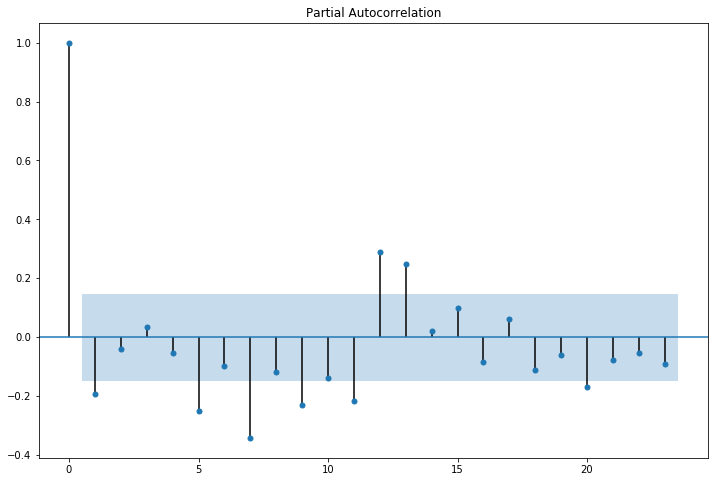

In [255]:
plot_pacf(df['Diff-1']);

# Comparison
* Heuristic Model
* Auto ARIMA Model
* Auto ARIMA Model with Seasonality

In [317]:
resultsDF = pd.DataFrame(columns=['RMSE', 'MAPE'])

# Heuristic Model
* http://people.duke.edu/~rnau/411arim.htm
* AR = 0 No strong AR pattern present
* I =  1 We found 1 difference as sufficient to acheive stationarity
* MA = 1 Found MA pattern in data
* Order (0, 1, 1)
* There appears to be a little seasonality in the data but we're stationary

In [318]:
model = ARIMA(df['Seen'], order=(0,1,1))
results = model.fit()

In [319]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Seen   No. Observations:                  175
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1089.101
Method:                       css-mle   S.D. of innovations            122.044
Date:                Tue, 28 Jan 2020   AIC                           2184.203
Time:                        05:30:04   BIC                           2193.697
Sample:                    06-01-2005   HQIC                          2188.054
                         - 12-01-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.6072      7.369      0.354      0.724     -11.836      17.051
ma.L1.D.Seen    -0.2024      0.076     -2.679      0.008      -0.351      -0.054
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            4.9399           +0.0000j            4.9399            0.0000
-----------------------------------------------------------------------------
"""

## Train - Test
* Last 12 points

In [320]:
size = len(df)

In [321]:
train = df.iloc[:size-12]
test  = df.iloc[size-12:]

## Fit Model

In [322]:
model = ARIMA(train['Seen'], order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Seen   No. Observations:                  163
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1014.665
Method:                       css-mle   S.D. of innovations            122.227
Date:                Tue, 28 Jan 2020   AIC                           2035.330
Time:                        05:30:04   BIC                           2044.611
Sample:                    06-01-2005   HQIC                          2039.098
                         - 12-01-2018                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.2547      7.735      0.162      0.871     -13.905      16.415
ma.L1.D.Seen    -0.1932      0.078     -2.486      0.014      -0.346      -0.041
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            5.1747           +0.0000j            5.1747            0.0000
-----------------------------------------------------------------------------
"""

## Predict Test
* Typ
    * Linear (in differenced values)
    * Levels (in original terms)

In [323]:
start = len(train)
end   = len(train) + len(test) - 1
preds = results.predict(start=start, end=end, typ='levels').rename('Predicted')
preds

2019-01-01    248.363201
2019-02-01    249.617935
2019-03-01    250.872668
2019-04-01    252.127401
2019-05-01    253.382134
2019-06-01    254.636868
2019-07-01    255.891601
2019-08-01    257.146334
2019-09-01    258.401068
2019-10-01    259.655801
2019-11-01    260.910534
2019-12-01    262.165267
Freq: MS, Name: Predicted, dtype: float64

## Plot

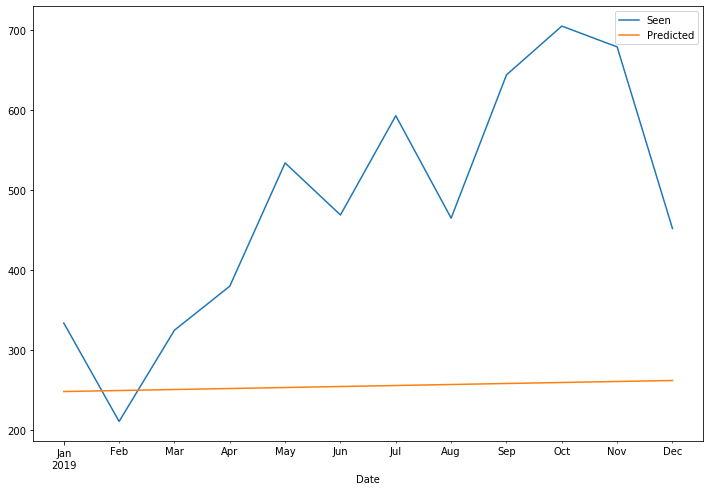

In [324]:
test['Seen'].plot(legend=True, figsize=(12,8))
preds.plot(legend=True);

## Error
* Error is pretty large relative to scale of the data

In [325]:
error = rmse(test['Seen'], preds)
print(f'RMSE = {error:.3f}')

RMSE = 269.269


In [326]:
mape = error * 100.0 / test['Seen'].mean()
print(f'MAPE = {mape:.3f}%')

MAPE = 55.797%


In [327]:
resultsDF.loc['Heuristic'] = [error, mape]

# AIC
* Akaike Information Criteria
* AIC = -2 (Log Likelihood) + 2K
    * K is the number of parameters in the model
    * Larger K = More Complex
    * Log-Likelihood is measure of model fit
    * Larger Log-Likelihood = Better Fit
* AIC penalizes a complex model
* All things equal, lower AIC is preferred
* BIC (Bayesian Information Criteria = More Penalty)

# Pyramid Auto-ARIMA

## Without Seasonality

In [328]:
fit = auto_arima(df['Seen'], start_p=0, start_q=0, max_p=3, max_q=3, seasonal=False, trace=True)

Fit ARIMA: order=(0, 1, 0); AIC=2189.109, BIC=2195.439, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=2184.455, BIC=2193.949, Fit time=0.023 seconds
Fit ARIMA: order=(0, 1, 1); AIC=2184.203, BIC=2193.697, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 1); AIC=2175.510, BIC=2188.169, Fit time=0.049 seconds
Fit ARIMA: order=(1, 1, 2); AIC=2178.888, BIC=2194.711, Fit time=0.087 seconds
Fit ARIMA: order=(2, 1, 2); AIC=2173.712, BIC=2192.701, Fit time=0.159 seconds
Fit ARIMA: order=(3, 1, 2); AIC=2175.838, BIC=2197.992, Fit time=0.313 seconds
Fit ARIMA: order=(2, 1, 1); AIC=2177.050, BIC=2192.874, Fit time=0.084 seconds
Fit ARIMA: order=(2, 1, 3); AIC=2175.709, BIC=2197.863, Fit time=0.216 seconds
Fit ARIMA: order=(3, 1, 3); AIC=2168.626, BIC=2193.944, Fit time=0.456 seconds
Total fit time: 1.414 seconds


In [329]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  175
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1076.313
Method:                       css-mle   S.D. of innovations            111.812
Date:                Tue, 28 Jan 2020   AIC                           2168.626
Time:                        05:30:05   BIC                           2193.944
Sample:                             1   HQIC                          2178.896
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8452      2.379      0.776      0.439      -2.817       6.507
ar.L1.D.y     -0.2598      0.084     -3.102      0.002      -0.424      -0.096
ar.L2.D.y     -0.2805      0.080     -3.504      0.001      -0.437      -0.124
ar.L3.D.y      0.7224      0.081      8.956      0.000       0.564       0.881
ma.L1.D.y      0.0332      0.062      0.536      0.593      -0.088       0.154
ma.L2.D.y      0.1076      0.058      1.868      0.064      -0.005       0.220
ma.L3.D.y     -0.9282      0.051    -18.137      0.000      -1.029      -0.828
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4949           -0.8715j            1.0022           -0.3322
AR.2           -0.4949           +0.8715j            1.0022            0.3322
AR.3            1.3781           -0.0000j            1.3781           -0.0000
MA.1           -0.4807           -0.8769j            1.0000           -0.3298
MA.2           -0.4807           +0.8769j            1.0000            0.3298
MA.3            1.0773           -0.0000j            1.0773           -0.0000
-----------------------------------------------------------------------------
"""

## Fit Model

In [330]:
model = ARIMA(train['Seen'], order=(3,1,3))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Seen   No. Observations:                  163
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1002.769
Method:                       css-mle   S.D. of innovations            112.023
Date:                Tue, 28 Jan 2020   AIC                           2021.537
Time:                        05:30:06   BIC                           2046.287
Sample:                    06-01-2005   HQIC                          2031.585
                         - 12-01-2018                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.2272      2.682      0.458      0.648      -4.030       6.484
ar.L1.D.Seen    -0.2609      0.086     -3.033      0.003      -0.429      -0.092
ar.L2.D.Seen    -0.2972      0.080     -3.721      0.000      -0.454      -0.141
ar.L3.D.Seen     0.7028      0.082      8.561      0.000       0.542       0.864
ma.L1.D.Seen     0.0229      0.065      0.351      0.726      -0.105       0.151
ma.L2.D.Seen     0.1404      0.062      2.275      0.024       0.019       0.261
ma.L3.D.Seen    -0.9158      0.052    -17.519      0.000      -1.018      -0.813
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4917           -0.8775j            1.0059           -0.3313
AR.2           -0.4917           +0.8775j            1.0059            0.3313
AR.3            1.4063           -0.0000j            1.4063           -0.0000
MA.1           -0.4693           -0.8830j            1.0000           -0.3278
MA.2           -0.4693           +0.8830j            1.0000            0.3278
MA.3            1.0920           -0.0000j            1.0920           -0.0000
-----------------------------------------------------------------------------
"""

## Predict Test

In [331]:
start = len(train)
end   = len(train) + len(test) - 1
preds = results.predict(start=start, end=end, typ='levels').rename('Predicted')
preds

2019-01-01    304.335399
2019-02-01    312.502787
2019-03-01    296.063405
2019-04-01    341.378796
2019-05-01    341.231653
2019-06-01    317.299673
2019-07-01    356.484408
2019-08-01    354.319704
2019-09-01    327.470054
2019-10-01    363.706851
2019-11-01    361.760296
2019-12-01    333.679209
Freq: MS, Name: Predicted, dtype: float64

## Plot

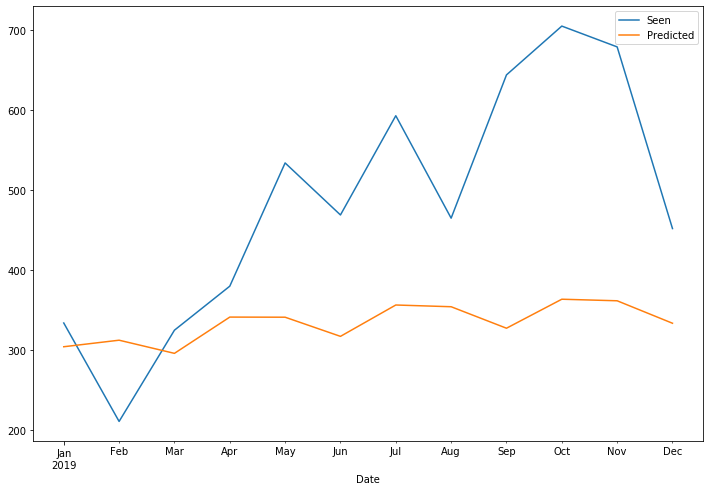

In [332]:
test['Seen'].plot(legend=True, figsize=(12,8))
preds.plot(legend=True);

## Error

In [333]:
error = rmse(test['Seen'], preds)
print(f'RMSE = {error:.3f}')

RMSE = 198.576


In [334]:
mape = error * 100.0 / test['Seen'].mean()
print(f'MAPE = {mape:.3f}%')

MAPE = 41.148%


In [335]:
resultsDF.loc['AutoARIMA'] = [error, mape]

# SARIMAX

## ARIMA Seasonality
* Note:  Our best model here was a ARIMA(0,1,1)x(1,0,1,12)
* It mirrored our heuristic based approach (0,1,1)
* WIth added seasonality annually (1,0,1,12)

In [336]:
fit_seasonal = auto_arima(df['Seen'], start_p=0, start_q=0, max_p=3, max_q=3, seasonal=True, m=12, trace=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 12); AIC=2139.049, BIC=2151.708, Fit time=0.225 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=2189.109, BIC=2195.439, Fit time=0.007 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=2139.393, BIC=2152.052, Fit time=0.141 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=2154.250, BIC=2166.910, Fit time=0.146 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=2164.279, BIC=2173.773, Fit time=0.083 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=2140.974, BIC=2156.798, Fit time=0.699 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=2156.253, BIC=2165.748, Fit time=0.079 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 2, 12); AIC=2140.919, BIC=2156.743, Fit time=0.720 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 2, 12); AIC=2141.842, BIC=2160.831, Fit time=1.006 seconds
Fit ARIMA: order=(1, 1, 0) s

In [337]:
fit_seasonal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1053.102
Date:                            Tue, 28 Jan 2020   AIC                           2116.203
Time:                                    05:30:23   BIC                           2132.027
Sample:                                         0   HQIC                          2122.622
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4841      1.363      0.355      0.722      -2.187       3.155
ma.L1         -0.4164      0.057     -7.249      0.000      -0.529      -0.304
ar.S.L12       0.9081      0.064     14.264      0.000       0.783       1.033
ma.S.L12      -0.6173      0.122     -5.044      0.000      -0.857      -0.377
sigma2      9481.1767    700.548     13.534      0.000    8108.128    1.09e+04
===================================================================================
Ljung-Box (Q):                       62.50   Jarque-Bera (JB):                45.48
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             0.23
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fit Model

In [338]:
model = SARIMAX(train['Seen'], order=(0,1,1), seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               Seen   No. Observations:                  164
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -977.899
Date:                            Tue, 28 Jan 2020   AIC                           1963.798
Time:                                    05:30:23   BIC                           1976.173
Sample:                                05-01-2005   HQIC                          1968.822
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4454      0.055     -8.082      0.000      -0.553      -0.337
ar.S.L12       0.9053      0.064     14.068      0.000       0.779       1.031
ma.S.L12      -0.5862      0.125     -4.706      0.000      -0.830      -0.342
sigma2      9081.2148    649.401     13.984      0.000    7808.412    1.04e+04
===================================================================================
Ljung-Box (Q):                       64.31   Jarque-Bera (JB):                63.78
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             0.28
Prob(H) (two-sided):                  0.08   Kurtosis:                         6.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predict Test

In [339]:
start = len(train)
end   = len(train) + len(test) - 1
preds = results.predict(start=start, end=end, typ='levels').rename('Predicted')
preds

2019-01-01    161.771111
2019-02-01    130.256553
2019-03-01    125.674952
2019-04-01    138.789271
2019-05-01    137.420656
2019-06-01    162.398723
2019-07-01    312.970824
2019-08-01    241.695584
2019-09-01    231.555592
2019-10-01    209.617529
2019-11-01    182.901729
2019-12-01    160.284829
Freq: MS, Name: Predicted, dtype: float64

## Plot

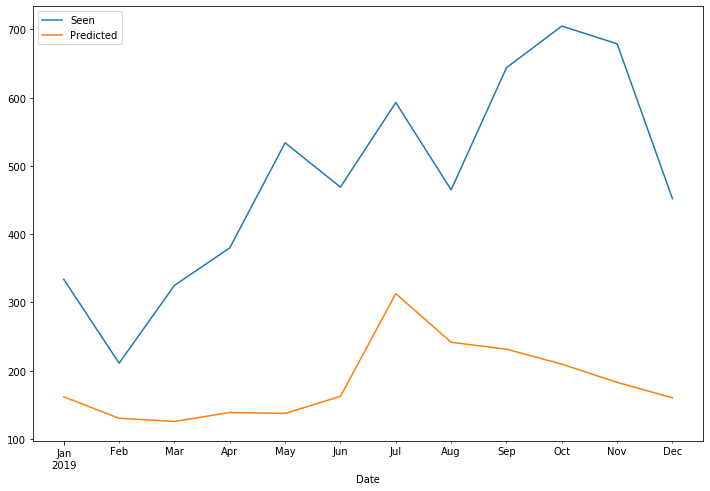

In [340]:
test['Seen'].plot(legend=True, figsize=(12,8))
preds.plot(legend=True);

## Error

In [341]:
error = rmse(test['Seen'], preds)
print(f'RMSE = {error:.3f}')

RMSE = 324.086


In [342]:
mape = error * 100.0 / test['Seen'].mean()
print(f'MAPE = {mape:.3f}%')

MAPE = 67.157%


In [343]:
resultsDF.loc['SARIMAX'] = [error, mape]

# Comparison

In [345]:
resultsDF

,RMSE,MAPE
Heuristic,269.268832,55.797375
AutoARIMA,198.575587,41.148455
SARIMAX,324.086090,67.156503


# ARIMA & ETS
* There common patterns and explanations around ARIMA and ETS
* For many ETS models there is an ARIMA analog (converse is not true)

## ARIMA(q,d,p)
* ARIMA (0,0,0) = White Noise
* ARIMA (0,1,0) = Random Walk
* ARIMA (0,1,0) + Constant = Random Walk + Drift
* ARIMA (1,0,0) + Constant = Regress Y on Lag Y(1)
* ARIMA (1,1,0) + Constant = Regress Y Diff(1) on Lag Y Diff(1)
* ARIMA (0,1,1) = Simple Exponential Smoothing
* ARIMA (0,2,2) = Holt Winters

## ETS(A,N,N)
* A = Type of Model (Additive, Multiplicative)
* N = Trend Component (None, Additive, Multiplicative, Automatic)
* N = Seasonal Component (None, Additive, Multiplicative, Automatic)

## Model Choice
* Help deciding between ARIMA and ETS 
    * Plot Data & Look for Trend & Seasonality --> ETS
    * Evidence of Autocorrelation --> ARIMA
    * Exogenous variables --> ARIMA
    * Compare techniques
* ARIMA(0,2,2) and Holt-Winters are equvalent
    * The UK Centre for the Measurement of Government Activity (UKCeMGA) Study
    * Question - Should they switch from ETS to ARIMA?
    * Tests
        * Multiple series
        * One step ahead prediction accuracy (MAE, MAPE)
        * ETS forecasts in ARIMA prediction interval
    * The paper concludes "...ultimately there is little difference in predictive performance between the Holt-Winters and ARIMA methods when producing one-step-ahead forecasts of components of quarterly estimates of public service output."
    * http://www.ons.gov.uk/ons/guide-method/ukcemga/publications-home/publications/archive/from-holt-winters-to-arima-modelling--measuring-the-impact-on-forecasting-errors-for-components-of-quarterly-estimates-of-public-service-output.pdf

In [ ]:
## 